In [1]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [5]:
# Set the root directory of the NIH Chest X-Ray images.
record_path = r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

# Recursively gather all PNG image paths.
image_paths = glob.glob(os.path.join(record_path, "**", "*.png"), recursive=True)

# Load the CSV containing image metadata and disease labels.
df = pd.read_csv(os.path.join(record_path, "Data_Entry_2017.csv"))

# Keep only relevant columns: "Image Index" and "Finding Labels".
df = df[["Image Index", "Finding Labels"]]
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [6]:
# Create a set of all disease labels found in the dataset.
diseases = set()
for findings in df["Finding Labels"].unique():
    for disease_label in findings.split("|"):
        diseases.add(disease_label)

# Initialize one-hot encoded columns for each disease.
for d in diseases:
    df[d] = 0

# Populate the one-hot encoded columns.
for index, row in df.iterrows():
    labels = row["Finding Labels"].split("|")
    for disease in labels:
        df.loc[index, disease] = 1

# Drop the original multi-label column.
df = df.drop("Finding Labels", axis=1)
df.head()

,Image Index,Cardiomegaly,Pneumonia,Infiltration,Pleural_Thickening,Nodule,Emphysema,Consolidation,Hernia,Atelectasis,No Finding,Edema,Pneumothorax,Fibrosis,Effusion,Mass
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


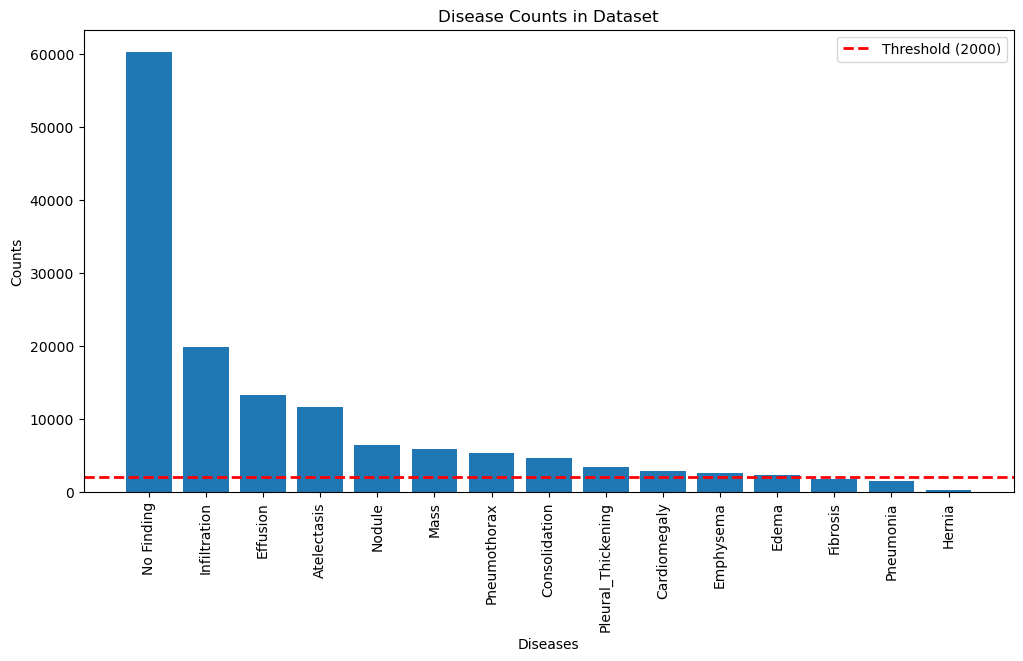

In [9]:
# Visualize Overall Disease Distribution
# Count occurrences for each disease.
counts = [df[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [12]:
# Create Training and Testing DataFrames Based on Provided File Lists

# Load training image names from file and filter the dataframe.
image_names_train = open(r"Cleaned Data Files\train_val_list.txt").read().split("\n")
df_train = df[df["Image Index"].isin(image_names_train)]

# Load testing image names from file and filter the dataframe.
image_names_test = open(r"Cleaned Data Files\test_list.txt").read().split("\n")
df_test = df[df["Image Index"].isin(image_names_test)]

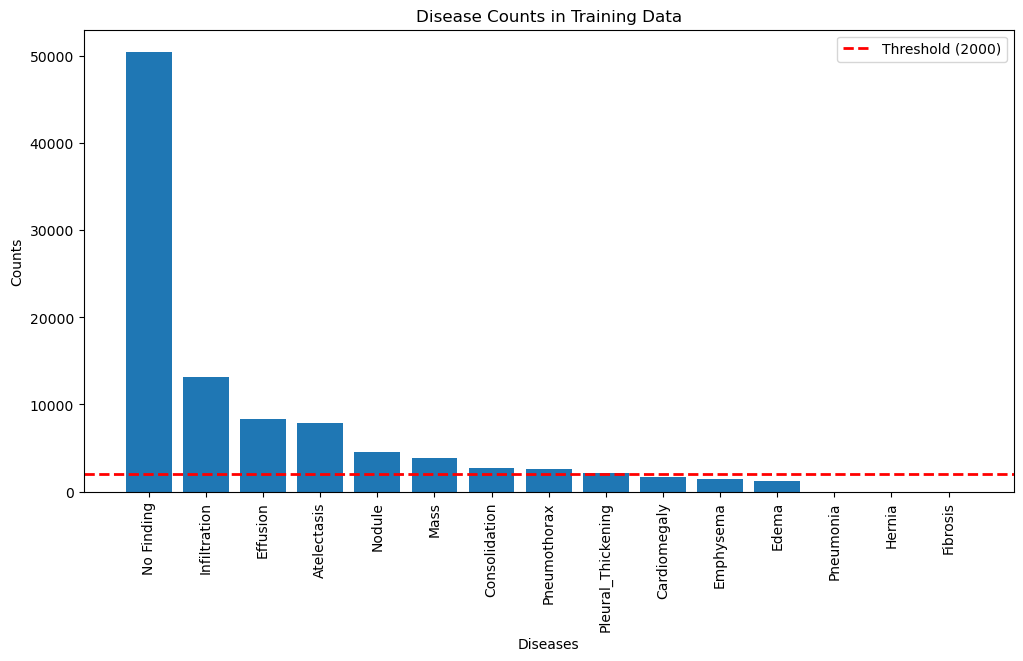

In [14]:
# Reload training data from a pre-saved parquet file 
df_train = pd.read_parquet(r"Cleaned Data Files\df_train.parquet")

# Count occurrences for each disease in the training set.
counts = [df_train[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Training Data')
plt.legend()
plt.show()

In [15]:
# Remove diseases with fewer than 2000 cases.
rare_diseases = [d[0] for d in disease_counts if d[1] < 2000]
print("Rare Diseases ( <2000 images ): ", rare_diseases)
for disease in rare_diseases:
    df_train = df_train[df_train[disease] != 1]

# Keep only the image index and the diseases that are not rare.
df_train = df_train[["Image Index"] + [i for i in diseases if i not in rare_diseases]]
# Drop the "No Finding" column, if present.
df_train = df_train.drop(columns="No Finding", errors='ignore')

Rare Diseases ( <2000 images ):  ['Cardiomegaly', 'Emphysema', 'Edema', 'Pneumonia', 'Hernia', 'Fibrosis']


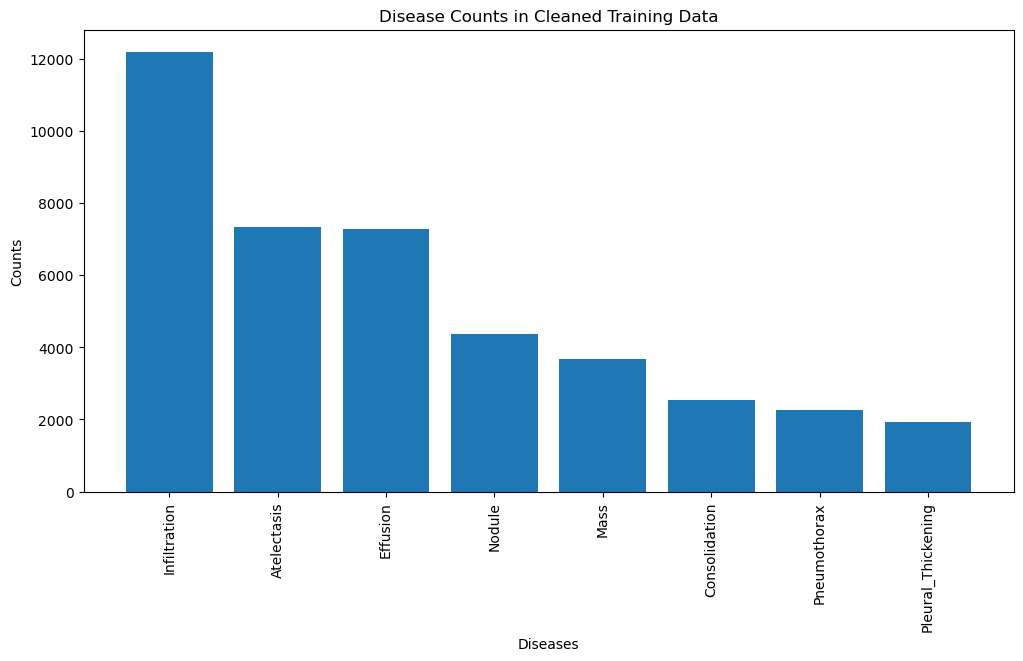

In [16]:
# Sanity-check: Plot the distribution in the cleaned training set.
disease_in_train = df_train.columns.tolist()[1:]
counts = [df_train[d].sum() for d in disease_in_train]
disease_counts = sorted(zip(disease_in_train, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Cleaned Training Data')
plt.show()

# Save the cleaned training data.
df_train.to_parquet("df_train_cleaned.parquet")

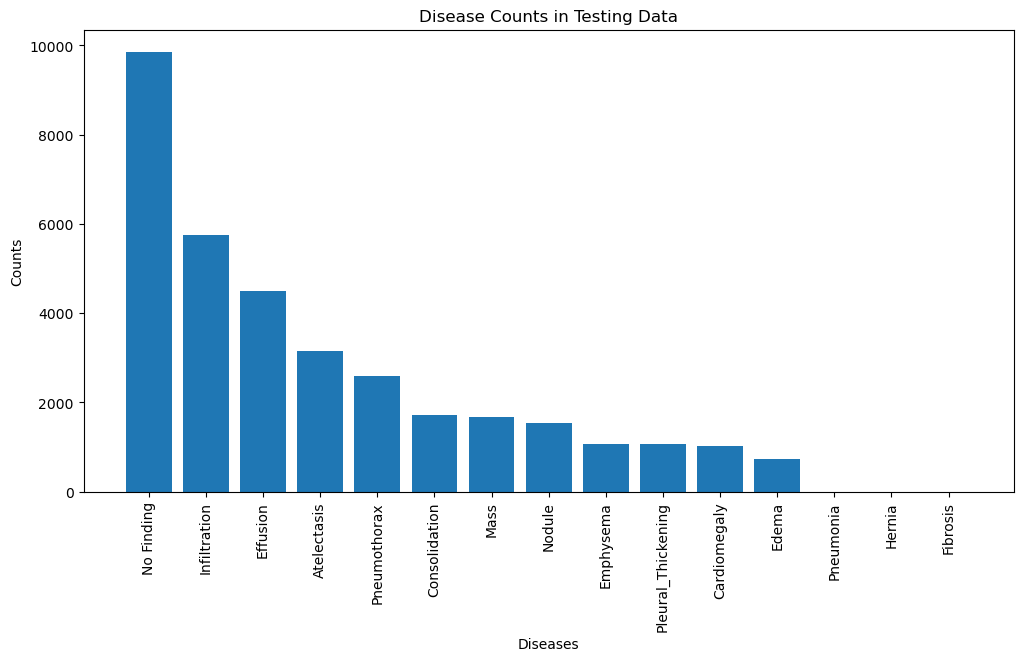

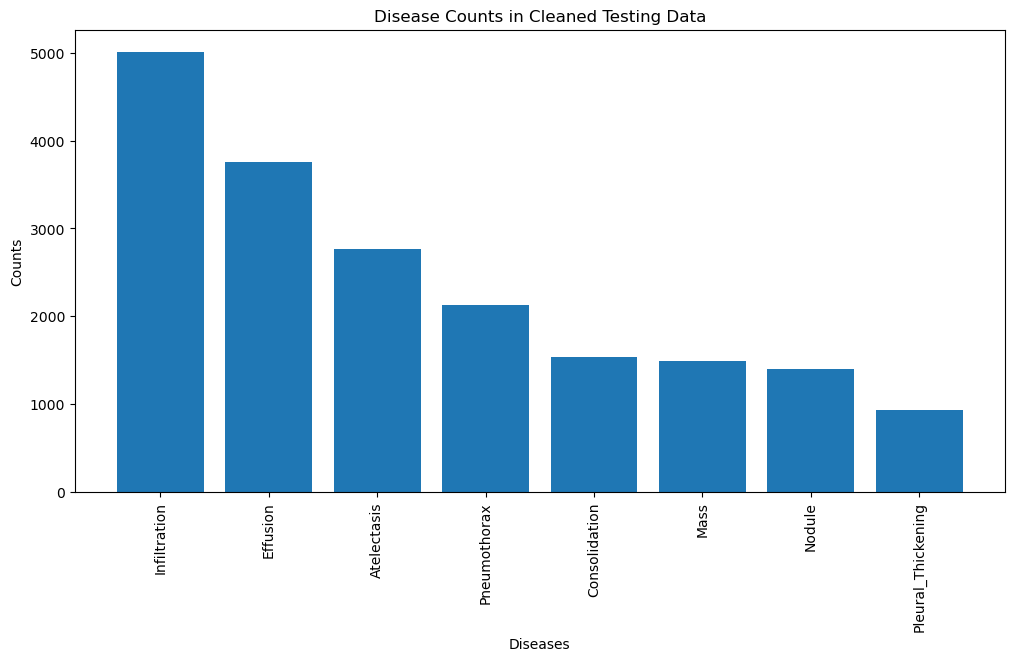

In [18]:
# Clean the Testing DataFrame (Repeat the same steps as Training)
df_test = pd.read_parquet(r"Cleaned Data Files\df_test.parquet")

# Visualize disease distribution in test data.
counts = [df_test[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Testing Data')
plt.show()

# Remove rare diseases from the test set as well.
for disease in rare_diseases:
    df_test = df_test[df_test[disease] != 1]

df_test = df_test[["Image Index"] + [i for i in diseases if i not in rare_diseases]]
df_test = df_test.drop(columns="No Finding", errors='ignore')

# Sanity-check: Plot the distribution in the cleaned test set.
disease_in_test = df_test.columns.tolist()[1:]
counts = [df_test[d].sum() for d in disease_in_test]
disease_counts = sorted(zip(disease_in_test, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Cleaned Testing Data')
plt.show()

# Save the cleaned testing data.
df_test.to_parquet("df_test_cleaned.parquet")